# 0. Important Metrics to collect

In [15]:
import os
import os
import json
from collections import Counter
import os, json
from collections import Counter

from utils import scan_and_export_json_files, read_json_files

# 1. Complete Dataset Metrics

#### Initialize root directory and output json file names if doesnt exist

In [14]:
root_directory = "/home/public/mkamal/datasets/deep_learning/projdata/uploadsed_data"
output_file = "video_json_files.txt"

# Check if output file already exists
if os.path.exists(output_file):
    print(f"Output file '{output_file}' already exists. Skipping extraction.")
else:
    print(f"Extracting JSON filenames from: {output_file}")
    scan_and_export_json_files(output_file=output_file)

# check for valid root
if not os.path.exists(output_file):
    print(f"{root_directory} is not a valid director. Please provide a valid directory")
else:
    print("Succesfully initialized root directory")
    print("="*80)

Output file 'video_json_files.txt' already exists. Skipping extraction.
Succesfully initialized root directory


#### Get Dataset Level Metrics

In [44]:
import os
import json
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np

def get_full_dataset_metrics(
    annotations_dir="/home/public/mkamal/datasets/deep_learning/projdata/uploaded_data/annotations",
    json_list_file="video_json_files.txt"
):
    """
    Calculate comprehensive metrics for the full dataset including object-level statistics.
    
    Args:
        annotations_dir: Path to annotations directory
        json_list_file: Path to text file containing list of JSON filenames
    """
    
    # Read the JSON files list
    if not os.path.exists(json_list_file):
        raise FileNotFoundError(f"JSON list file not found: {json_list_file}. Run scan_and_export_json_files() first.")
    
    json_files = read_json_files(json_list_file)
    
    # ==================== VIDEO-LEVEL METRICS ====================
    total_videos = 0
    total_frames = 0
    normal_frames = 0
    anomaly_frames = 0
    
    video_lengths = []
    anomaly_durations = []
    pre_anomaly_durations = []
    post_anomaly_durations = []
    total_normal_frames_list = []
    
    anomaly_types = Counter()
    
    # Video metadata counts
    ego_involve_count = 0
    night_count = 0
    ignore_count = 0
    
    
    # ==================== OBJECT-LEVEL METRICS ====================
    total_objects = 0
    objects_per_frame = []
    object_categories = Counter()
    
    # Objects in different contexts
    objects_in_normal_frames = 0
    objects_in_anomaly_frames = 0
    objects_in_pre_anomaly = 0
    objects_in_post_anomaly = 0
    
    # Per-video object stats
    videos_with_objects = 0
    objects_per_video = []
    
    # ==================== CATEGORY-SPECIFIC METRICS ====================
    category_in_normal = Counter()
    category_in_anomaly = Counter()
    

    # ==================== PROCESS EACH VIDEO ====================
    for file_name in json_files:
        file_path = os.path.join(annotations_dir, file_name)
        
        if not os.path.exists(file_path):
            print(f"Warning: File not found: {file_path}")
            continue

        try:
            with open(file_path, "r") as f:
                data = json.load(f)
        except json.JSONDecodeError as e:
            print(f"Warning: Failed to parse JSON in {file_name}: {e}")
            continue

        total_videos += 1
        labels = data["labels"]
        num_frames = len(labels)
        video_lengths.append(num_frames)
        total_frames += num_frames
        
        # Video metadata
        if data.get("ego_involve", False):
            ego_involve_count += 1
        if data.get("night", False):
            night_count += 1
        if data.get("ignore", False):
            ignore_count += 1

        anomaly_start = data.get("anomaly_start")
        anomaly_end = data.get("anomaly_end")
        
        # Track objects in this video
        video_object_count = 0
        video_has_objects = False

        # Process each frame
        for frame in labels:
            frame_objects = frame.get("objects", [])
            num_objects_in_frame = len(frame_objects)
            
            if num_objects_in_frame > 0:
                video_has_objects = True
                video_object_count += num_objects_in_frame
                total_objects += num_objects_in_frame
                objects_per_frame.append(num_objects_in_frame)
                
                # Process each object
                for obj in frame_objects:
                    # Category information
                    category = obj.get("category", "unknown")
                    object_categories[category] += 1
            else:
                objects_per_frame.append(0)
            
            # Determine frame context and count objects
            frame_id = frame["frame_id"]
            
            if anomaly_start is not None and anomaly_end is not None:
                if frame_id < anomaly_start:
                    # Pre-anomaly frame
                    objects_in_pre_anomaly += num_objects_in_frame
                    for obj in frame_objects:
                        category = obj.get("category", "unknown")
                        category_in_normal[category] += 1
                        
                elif frame_id >= anomaly_start and frame_id <= anomaly_end:
                    # Anomaly frame
                    objects_in_anomaly_frames += num_objects_in_frame
                    for obj in frame_objects:
                        category = obj.get("category", "unknown")
                        category_in_anomaly[category] += 1
                        
                else:
                    # Post-anomaly frame
                    objects_in_post_anomaly += num_objects_in_frame
                    for obj in frame_objects:
                        category = obj.get("category", "unknown")
                        category_in_normal[category] += 1
            else:
                # Entire video is normal
                objects_in_normal_frames += num_objects_in_frame
                for obj in frame_objects:
                    category = obj.get("category", "unknown")
                    category_in_normal[category] += 1
        
        # Record per-video object stats
        if video_has_objects:
            videos_with_objects += 1
            objects_per_video.append(video_object_count)

        # Calculate frame-level statistics
        if anomaly_start is not None and anomaly_end is not None:
            # Anomaly duration
            a_dur = anomaly_end - anomaly_start + 1
            anomaly_frames += a_dur
            anomaly_durations.append(a_dur)

            # Anomaly type (count by frames)
            anom_type = data.get("accident_name", "unknown")
            anomaly_types[anom_type] += a_dur

            # Pre- and post-anomaly frames
            pre = anomaly_start
            post = num_frames - (anomaly_end + 1)
            pre_anomaly_durations.append(pre)
            post_anomaly_durations.append(post)
            total_normal_frames_list.append(pre + post)

            normal_frames += pre + post
        else:
            # Whole video is normal
            total_normal_frames_list.append(num_frames)
            normal_frames += num_frames

    
    # ==================== COMPUTE DERIVED METRICS ====================
    
    # Video-level derived metrics
    anomaly_ratio = anomaly_frames / total_frames if total_frames > 0 else 0
    avg_video_length = sum(video_lengths) / len(video_lengths) if video_lengths else 0
    avg_anomaly_duration = (sum(anomaly_durations) / len(anomaly_durations)
                            if anomaly_durations else 0)
    avg_normal_frame = (sum(total_normal_frames_list) / total_videos) if total_videos > 0 else 0
    
    # Object-level derived metrics
    avg_objects_per_frame = total_objects / total_frames if total_frames > 0 else 0
    avg_objects_per_video = sum(objects_per_video) / len(objects_per_video) if objects_per_video else 0
    videos_with_objects_pct = (videos_with_objects / total_videos * 100) if total_videos > 0 else 0
    
    # Objects in normal vs anomaly contexts
    total_normal_context_objects = objects_in_normal_frames + objects_in_pre_anomaly + objects_in_post_anomaly
    object_anomaly_ratio = (objects_in_anomaly_frames / total_objects * 100) if total_objects > 0 else 0

    print(f"Processed {total_videos} videos from {json_list_file}")
    print(f"Found {total_objects} total objects across all frames")

    return {
        # ==================== VIDEO-LEVEL METRICS ====================
        "total_videos": total_videos,
        "total_frames": total_frames,
        "normal_frames": normal_frames,
        "anomaly_frames": anomaly_frames,
        "anomaly_ratio": anomaly_ratio,
        
        "avg_video_length": avg_video_length,
        "avg_anomaly_duration": avg_anomaly_duration,
        "avg_normal_duration": avg_normal_frame,
        
        "anomaly_durations": anomaly_durations,
        "total_normal_frame_list": total_normal_frames_list,
        "pre_anomaly_durations": pre_anomaly_durations,
        "post_anomaly_durations": post_anomaly_durations,
        
        "anomaly_types": anomaly_types,
        
        
        # ==================== VIDEO METADATA METRICS ====================
        "ego_involve_count": ego_involve_count,
        "night_count": night_count,
        "ignore_count": ignore_count,
        
        
        # ==================== OBJECT-LEVEL METRICS ====================
        "total_objects": total_objects,
        "avg_objects_per_frame": avg_objects_per_frame,
        "avg_objects_per_video": avg_objects_per_video,
        
        "videos_with_objects": videos_with_objects,
        "videos_with_objects_pct": videos_with_objects_pct,
        "objects_per_video_list": objects_per_video,
        "objects_per_frame_list": objects_per_frame,
        
        "object_categories": object_categories,
        
        
        # ==================== OBJECT CONTEXT METRICS ====================
        "objects_in_normal_frames": objects_in_normal_frames,
        "objects_in_anomaly_frames": objects_in_anomaly_frames,
        "objects_in_pre_anomaly": objects_in_pre_anomaly,
        "objects_in_post_anomaly": objects_in_post_anomaly,
        "total_normal_context_objects": total_normal_context_objects,
        "object_anomaly_ratio": object_anomaly_ratio,
        
        
        # ==================== CATEGORY-SPECIFIC METRICS ====================
        "category_in_normal": category_in_normal,
        "category_in_anomaly": category_in_anomaly,
    }



    """
    Create separate visualization plots for each metric.
    
    Args:
        metrics: Dictionary containing dataset metrics
        output_dir: Directory to save plots
    """
    
    # 1. DURATION DISTRIBUTIONS (4 histograms in one figure)
    # ====================================================================
    fig1 = plt.figure(figsize=(16, 10))
    
    # Anomaly Frames Distribution
    ax1 = plt.subplot(2, 2, 1)
    if metrics['anomaly_durations']:
        ax1.hist(metrics['anomaly_durations'], bins=30, edgecolor='black', alpha=0.7, color='#e74c3c')
        ax1.axvline(metrics['avg_anomaly_duration'], color='darkred', linestyle='--', 
                   linewidth=2, label=f'Mean: {metrics["avg_anomaly_duration"]:.1f}')
        ax1.legend()
    ax1.set_xlabel('Number of Frames', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.set_title('Anomaly Frames Distribution', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Pre-Anomalous Frames Distribution
    ax2 = plt.subplot(2, 2, 2)
    if metrics['pre_anomaly_durations']:
        ax2.hist(metrics['pre_anomaly_durations'], bins=30, edgecolor='black', alpha=0.7, color='#f39c12')
        mean_pre = np.mean(metrics['pre_anomaly_durations'])
        ax2.axvline(mean_pre, color='darkorange', linestyle='--', 
                   linewidth=2, label=f'Mean: {mean_pre:.1f}')
        ax2.legend()
    ax2.set_xlabel('Number of Frames', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title('Pre-Anomalous Frames Distribution', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Post-Anomalous Frames Distribution
    ax3 = plt.subplot(2, 2, 3)
    if metrics['post_anomaly_durations']:
        ax3.hist(metrics['post_anomaly_durations'], bins=30, edgecolor='black', alpha=0.7, color='#27ae60')
        mean_post = np.mean(metrics['post_anomaly_durations'])
        ax3.axvline(mean_post, color='darkgreen', linestyle='--', 
                   linewidth=2, label=f'Mean: {mean_post:.1f}')
        ax3.legend()
    ax3.set_xlabel('Number of Frames', fontsize=12)
    ax3.set_ylabel('Frequency', fontsize=12)
    ax3.set_title('Post-Anomalous Frames Distribution', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # Normal Frames Distribution (per video)
    ax4 = plt.subplot(2, 2, 4)
    if metrics['total_normal_frame_list']:
        ax4.hist(metrics['total_normal_frame_list'], bins=30, edgecolor='black', alpha=0.7, color='#3498db')
        ax4.axvline(metrics['avg_normal_duration'], color='darkblue', linestyle='--', 
                   linewidth=2, label=f'Mean: {metrics["avg_normal_duration"]:.1f}')
        ax4.legend()
    ax4.set_xlabel('Number of Frames', fontsize=12)
    ax4.set_ylabel('Frequency', fontsize=12)
    ax4.set_title('Normal Frames Distribution (per video)', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    fig1.savefig(f'{output_dir}/1_duration_distributions.png', dpi=300, bbox_inches='tight')
    print(f"Saved: {output_dir}/1_duration_distributions.png")
    plt.close(fig1)
    
    
    # 2. VIDEO METADATA STATISTICS
    # ====================================================================
    fig2 = plt.figure(figsize=(12, 5))
    
    # Ego Involvement Count
    ax1 = plt.subplot(1, 2, 1)
    metadata_labels = ['Ego Involved', 'Ego Not Involved']
    metadata_counts = [
        metrics['ego_involve_count'],
        metrics['total_videos'] - metrics['ego_involve_count']
    ]
    colors = ['#e74c3c', '#3498db']
    bars = ax1.bar(metadata_labels, metadata_counts, color=colors, alpha=0.7, edgecolor='black', width=0.6)
    ax1.set_ylabel('Number of Videos', fontsize=12)
    ax1.set_title('Ego Involvement Distribution', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Night vs Day
    ax2 = plt.subplot(1, 2, 2)
    time_labels = ['Night', 'Day']
    time_counts = [
        metrics['night_count'],
        metrics['total_videos'] - metrics['night_count']
    ]
    colors2 = ['#34495e', '#f39c12']
    bars2 = ax2.bar(time_labels, time_counts, color=colors2, alpha=0.7, edgecolor='black', width=0.6)
    ax2.set_ylabel('Number of Videos', fontsize=12)
    ax2.set_title('Time of Day Distribution', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    # Add value labels
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    fig2.savefig(f'{output_dir}/2_video_metadata.png', dpi=300, bbox_inches='tight')
    print(f"Saved: {output_dir}/2_video_metadata.png")
    plt.close(fig2)
    
    
    # 3. FRAME DISTRIBUTION (Normal vs Anomaly)
    # ====================================================================
    fig3 = plt.figure(figsize=(10, 6))
    ax = plt.subplot(1, 1, 1)
    
    frame_types = ['Normal Frames', 'Anomaly Frames']
    frame_counts = [metrics['normal_frames'], metrics['anomaly_frames']]
    colors = ['#27ae60', '#e74c3c']
    bars = ax.bar(frame_types, frame_counts, color=colors, alpha=0.7, edgecolor='black', width=0.5)
    
    ax.set_ylabel('Number of Frames', fontsize=13)
    ax.set_title('Frame Distribution (Normal vs Anomaly)', fontsize=15, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels and percentages
    for i, bar in enumerate(bars):
        height = bar.get_height()
        percentage = (height / metrics['total_frames']) * 100
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}\n({percentage:.1f}%)',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    fig3.savefig(f'{output_dir}/3_frame_distribution.png', dpi=300, bbox_inches='tight')
    print(f"Saved: {output_dir}/3_frame_distribution.png")
    plt.close(fig3)
    
    
    # 4. DISTRIBUTION OF ANOMALY TYPES
    # ====================================================================
    fig4 = plt.figure(figsize=(12, 8))
    ax = plt.subplot(1, 1, 1)
    
    # Sort by count
    sorted_anomalies = sorted(metrics['anomaly_types'].items(), key=lambda x: x[1], reverse=True)
    anomaly_names = [item[0] for item in sorted_anomalies]
    anomaly_counts = [item[1] for item in sorted_anomalies]
    
    bars = ax.barh(anomaly_names, anomaly_counts, color='#e67e22', edgecolor='black', alpha=0.7)
    ax.set_xlabel('Number of Frames', fontsize=12)
    ax.set_title('Distribution of Anomaly Types', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, (bar, count) in enumerate(zip(bars, anomaly_counts)):
        ax.text(count, i, f' {count}', va='center', fontsize=10)
    
    plt.tight_layout()
    fig4.savefig(f'{output_dir}/4_anomaly_types.png', dpi=300, bbox_inches='tight')
    print(f"Saved: {output_dir}/4_anomaly_types.png")
    plt.close(fig4)
    
    
    # 5. PIE CHART: Total Anomaly Objects per Video (combine >=5)
    # ====================================================================
    fig5 = plt.figure(figsize=(10, 8))
    ax = plt.subplot(1, 1, 1)
    
    # Categorize objects per video: 0, 1, 2, 3, 4, >=5
    categories = {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '≥5': 0}
    
    for count in metrics['objects_per_video_list']:
        if count >= 5:
            categories['≥5'] += 1
        elif count in [0, 1, 2, 3, 4]:
            categories[str(count)] += 1
    
    labels = [f'{k} objects\n({v} videos)' for k, v in categories.items() if v > 0]
    sizes = [v for v in categories.values() if v > 0]
    colors_pie = plt.cm.Set3(range(len(sizes)))
    
    wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', 
                                        startangle=90, colors=colors_pie,
                                        textprops={'fontsize': 11})
    
    # Make percentage text bold
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontweight('bold')
    
    ax.set_title('Total Anomaly Objects per Video Distribution', fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    fig5.savefig(f'{output_dir}/5_anomaly_objects_per_video.png', dpi=300, bbox_inches='tight')
    print(f"Saved: {output_dir}/5_anomaly_objects_per_video.png")
    plt.close(fig5)
    
    
    # 6. PIE CHART: Ego Car Involvement in Accidents
    # ====================================================================
    fig6 = plt.figure(figsize=(10, 8))
    ax = plt.subplot(1, 1, 1)
    
    labels_ego = ['Ego Involved\nin Accident', 'Ego Not Involved\nin Accident']
    sizes_ego = [
        metrics['ego_involve_count'],
        metrics['total_videos'] - metrics['ego_involve_count']
    ]
    colors_ego = ['#e74c3c', '#2ecc71']
    
    wedges, texts, autotexts = ax.pie(sizes_ego, labels=labels_ego, autopct='%1.1f%%', 
                                        startangle=90, colors=colors_ego,
                                        textprops={'fontsize': 12})
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(13)
    
    ax.set_title('Ego Car Involvement in Accidents', fontsize=15, fontweight='bold', pad=20)
    
    plt.tight_layout()
    fig6.savefig(f'{output_dir}/6_ego_involvement.png', dpi=300, bbox_inches='tight')
    print(f"Saved: {output_dir}/6_ego_involvement.png")
    plt.close(fig6)
    
    
    # 7. PIE CHART: Non-Ego Objects in Anomaly vs Normal Context
    # ====================================================================
    fig7 = plt.figure(figsize=(10, 8))
    ax = plt.subplot(1, 1, 1)
    
    # Calculate non-ego objects in different contexts
    non_ego_in_anomaly = 0
    non_ego_in_normal = 0
    
    for category, count in metrics['category_in_anomaly'].items():
        if category.lower() != 'ego_car':
            non_ego_in_anomaly += count
    
    for category, count in metrics['category_in_normal'].items():
        if category.lower() != 'ego_car':
            non_ego_in_normal += count
    
    labels_non_ego = ['Non-Ego Objects\nin Anomaly Frames', 'Non-Ego Objects\nin Normal Frames']
    sizes_non_ego = [non_ego_in_anomaly, non_ego_in_normal]
    colors_non_ego = ['#e67e22', '#3498db']
    
    wedges, texts, autotexts = ax.pie(sizes_non_ego, labels=labels_non_ego, autopct='%1.1f%%',
                                        startangle=90, colors=colors_non_ego,
                                        textprops={'fontsize': 12})
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(13)
    
    ax.set_title('Non-Ego Objects: Anomaly vs Normal Context', fontsize=15, fontweight='bold', pad=20)
    
    plt.tight_layout()
    fig7.savefig(f'{output_dir}/7_non_ego_context.png', dpi=300, bbox_inches='tight')
    print(f"Saved: {output_dir}/7_non_ego_context.png")
    plt.close(fig7)
    
    
    # 8. PIE CHART: Object Categories Distribution
    # ====================================================================
    fig8 = plt.figure(figsize=(12, 10))
    ax = plt.subplot(1, 1, 1)
    
    # Sort categories by count
    sorted_categories = sorted(metrics['object_categories'].items(), key=lambda x: x[1], reverse=True)
    
    # Take top categories and combine the rest if there are many
    if len(sorted_categories) > 10:
        top_categories = sorted_categories[:9]
        other_count = sum(count for _, count in sorted_categories[9:])
        top_categories.append(('Others', other_count))
    else:
        top_categories = sorted_categories
    
    labels_cat = [f'{cat}\n({count})' for cat, count in top_categories]
    sizes_cat = [count for _, count in top_categories]
    colors_cat = plt.cm.tab20(range(len(sizes_cat)))
    
    wedges, texts, autotexts = ax.pie(sizes_cat, labels=labels_cat, autopct='%1.1f%%',
                                        startangle=90, colors=colors_cat,
                                        textprops={'fontsize': 10})
    
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontweight('bold')
    
    ax.set_title('Object Categories Distribution', fontsize=15, fontweight='bold', pad=20)
    
    plt.tight_layout()
    fig8.savefig(f'{output_dir}/8_object_categories.png', dpi=300, bbox_inches='tight')
    print(f"Saved: {output_dir}/8_object_categories.png")
    plt.close(fig8)
    
    print(f"\nAll plots saved successfully to {output_dir}")

def plot_statistics(metrics):
    """
    Create separate visualization plots for each metric.
    
    Args:
        metrics: Dictionary containing dataset metrics
    """
    
    # 1. DURATION DISTRIBUTIONS (4 histograms in one figure)
    # ====================================================================
    # 1. DURATION DISTRIBUTIONS (All in one plot)
    # ====================================================================
    fig1 = plt.figure(figsize=(8, 5))
    ax = plt.subplot(1, 1, 1)
    
    # Plot all distributions on the same axis with transparency
    if metrics['anomaly_durations']:
        ax.hist(metrics['anomaly_durations'], bins=70, edgecolor='black', alpha=0.8, 
                color='#e74c3c', label='Anomaly Frames')
    
    if metrics['pre_anomaly_durations']:
        ax.hist(metrics['pre_anomaly_durations'], bins=70, edgecolor='black', alpha=0.3, 
                color='#f39c12', label='Pre-Anomalous Frames')
    
    if metrics['post_anomaly_durations']:
        ax.hist(metrics['post_anomaly_durations'], bins=70, edgecolor='black', alpha=0.3, 
                color='#27ae60', label='Post-Anomalous Frames')
    
    if metrics['total_normal_frame_list']:
        ax.hist(metrics['total_normal_frame_list'], bins=70, edgecolor='black', alpha=0.3, 
                color='#3498db', label='Normal Frames (per video)')
    
    ax.set_xlabel('Number of Frames', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('Frame Duration Distributions', fontsize=13, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    
    # 2. VIDEO METADATA STATISTICS
    # ====================================================================
    fig2 = plt.figure(figsize=(10, 4))
    
    # Ego Involvement Count
    ax1 = plt.subplot(1, 2, 1)
    metadata_labels = ['Ego Involved', 'Ego Not Involved']
    metadata_counts = [
        metrics['ego_involve_count'],
        metrics['total_videos'] - metrics['ego_involve_count']
    ]
    colors = ['#e74c3c', '#3498db']
    bars = ax1.bar(metadata_labels, metadata_counts, color=colors, alpha=0.7, edgecolor='black', width=0.6)
    ax1.set_ylabel('Number of Videos', fontsize=11)
    ax1.set_title('Ego Involvement Distribution', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Night vs Day
    ax2 = plt.subplot(1, 2, 2)
    time_labels = ['Night', 'Day']
    time_counts = [
        metrics['night_count'],
        metrics['total_videos'] - metrics['night_count']
    ]
    colors2 = ['#34495e', '#f39c12']
    bars2 = ax2.bar(time_labels, time_counts, color=colors2, alpha=0.7, edgecolor='black', width=0.6)
    ax2.set_ylabel('Number of Videos', fontsize=11)
    ax2.set_title('Time of Day Distribution', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    # Add value labels
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    
    # 3. FRAME DISTRIBUTION (Normal vs Anomaly) - PIE CHART
    # ====================================================================
    fig3 = plt.figure(figsize=(8, 6))
    ax = plt.subplot(1, 1, 1)
    
    frame_types = ['Normal Frames', 'Anomaly Frames']
    frame_counts = [metrics['normal_frames'], metrics['anomaly_frames']]
    colors = ['#27ae60', '#e74c3c']
    
    wedges, texts, autotexts = ax.pie(frame_counts, labels=frame_types, autopct='%1.1f%%',
                                        startangle=90, colors=colors,
                                        textprops={'fontsize': 11})
    
    # Add counts to labels
    for i, (text, count) in enumerate(zip(texts, frame_counts)):
        text.set_text(f'{frame_types[i]}\n({count:,})')
        text.set_fontsize(11)
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(12)
    
    ax.set_title('Frame Distribution (Normal vs Anomaly)', fontsize=13, fontweight='bold', pad=15)
    
    plt.tight_layout()
    plt.show()
    
    
    # 4. DISTRIBUTION OF ANOMALY TYPES
    # ====================================================================
    fig4 = plt.figure(figsize=(10, 6))
    ax = plt.subplot(1, 1, 1)
    
    # Sort by count
    sorted_anomalies = sorted(metrics['anomaly_types'].items(), key=lambda x: x[1], reverse=True)
    anomaly_names = [item[0] for item in sorted_anomalies]
    anomaly_counts = [item[1] for item in sorted_anomalies]
    
    bars = ax.barh(anomaly_names, anomaly_counts, color='#e67e22', edgecolor='black', alpha=0.7)
    ax.set_xlabel('Number of Frames', fontsize=11)
    ax.set_title('Distribution of Anomaly Types', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, (bar, count) in enumerate(zip(bars, anomaly_counts)):
        ax.text(count, i, f' {count}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    
    # 5. PIE CHART: Ego Car Involvement in Accidents
    # ====================================================================
    fig5 = plt.figure(figsize=(8, 6))
    ax = plt.subplot(1, 1, 1)
    
    labels_ego = ['Ego Involved\nin Accident', 'Ego Not Involved\nin Accident']
    sizes_ego = [
        metrics['ego_involve_count'],
        metrics['total_videos'] - metrics['ego_involve_count']
    ]
    colors_ego = ['#e74c3c', '#2ecc71']
    
    wedges, texts, autotexts = ax.pie(sizes_ego, labels=labels_ego, autopct='%1.1f%%', 
                                        startangle=90, colors=colors_ego,
                                        textprops={'fontsize': 11})
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(12)
    
    ax.set_title('Ego Car Involvement in Accidents', fontsize=13, fontweight='bold', pad=15)
    
    plt.tight_layout()
    plt.show()
    
    
    # # 6. PIE CHART: Object Categories Distribution
    # # ====================================================================
    # fig6 = plt.figure(figsize=(10, 8))
    # ax = plt.subplot(1, 1, 1)
    
    # # Sort categories by count
    # sorted_categories = sorted(metrics['object_categories'].items(), key=lambda x: x[1], reverse=True)
    
    # # Take top categories and combine the rest if there are many
    # if len(sorted_categories) > 10:
    #     top_categories = sorted_categories[:9]
    #     other_count = sum(count for _, count in sorted_categories[9:])
    #     top_categories.append(('Others', other_count))
    # else:
    #     top_categories = sorted_categories
    
    # labels_cat = [f'{cat}\n({count})' for cat, count in top_categories]
    # sizes_cat = [count for _, count in top_categories]
    # colors_cat = plt.cm.tab20(range(len(sizes_cat)))
    
    # wedges, texts, autotexts = ax.pie(sizes_cat, labels=labels_cat, autopct='%1.1f%%',
    #                                     startangle=90, colors=colors_cat,
    #                                     textprops={'fontsize': 9})
    
    # for autotext in autotexts:
    #     autotext.set_color('black')
    #     autotext.set_fontweight('bold')
    #     autotext.set_fontsize(10)
    
    # ax.set_title('Object Categories Distribution', fontsize=13, fontweight='bold', pad=15)
    
    # plt.tight_layout()
    # plt.show()

Processed 4677 videos from video_json_files.txt
Found 170739 total objects across all frames
Total Frames: 477,655
Normal Frames: 316,250 (66.21%)
Anomaly Frames: 161,405 (33.79%)

Average Video Length: 102.13 frames
Average Anomaly Duration: 34.51 frames (std: 20.08)
Average Normal Duration: 67.62 frames (std: 27.41)
Average Pre-Anomaly Duration: 38.05 frames (std: 17.62)
Average Post-Anomaly Duration: 29.56 frames (std: 22.75)


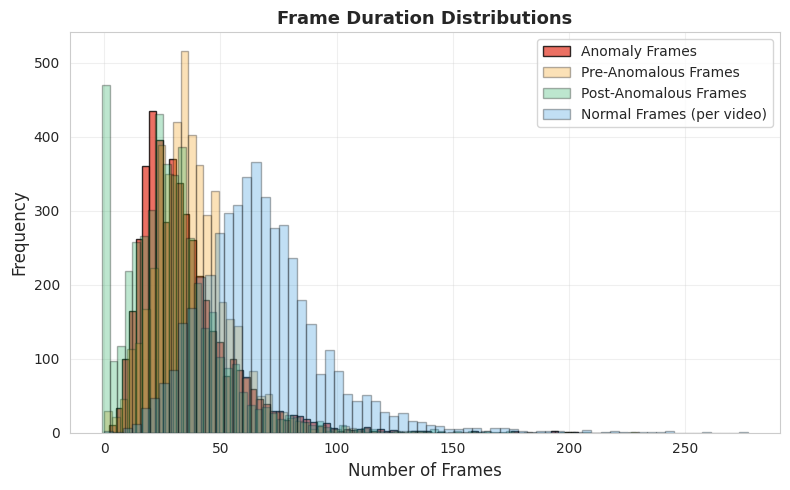

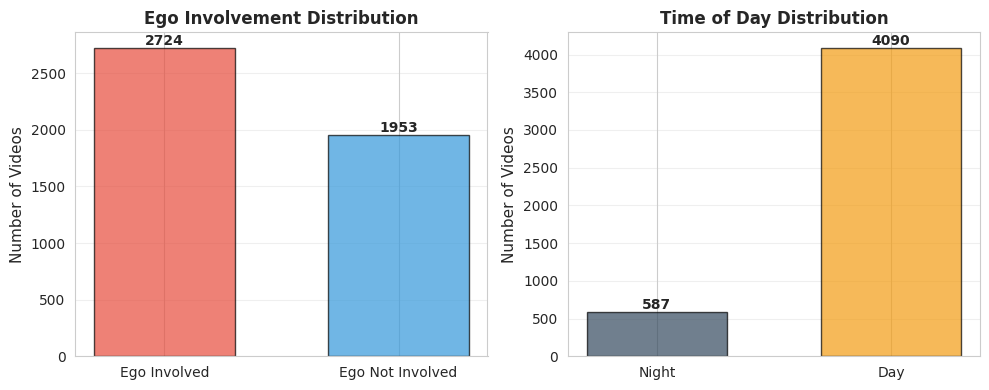

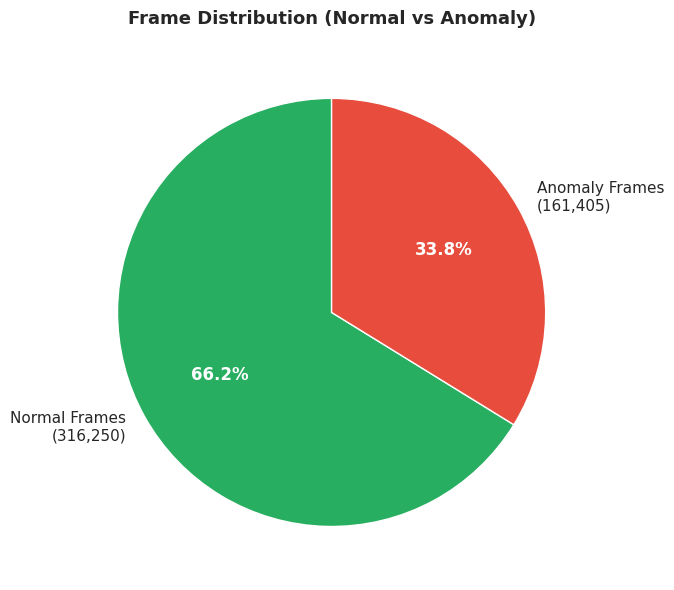

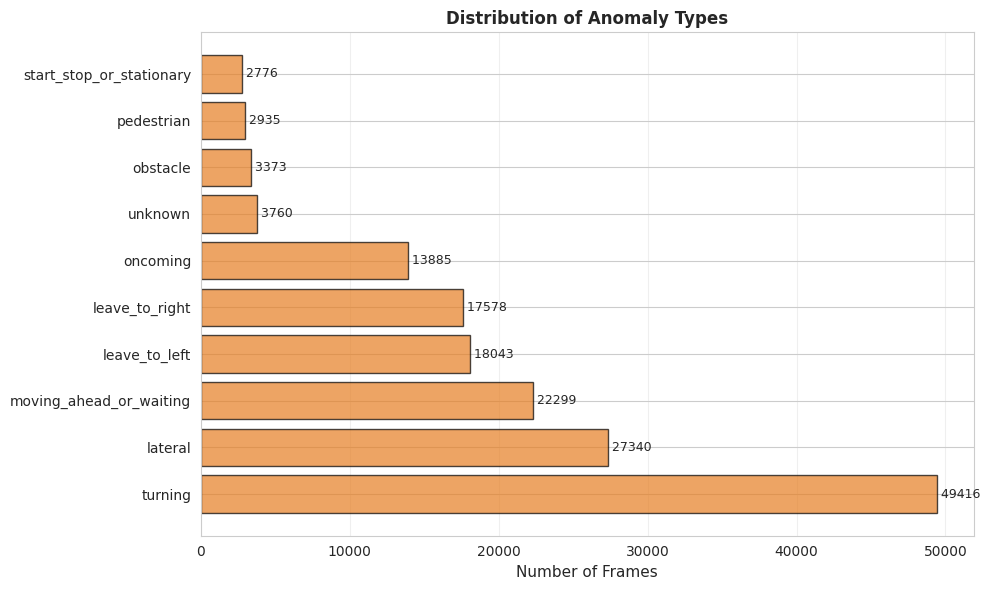

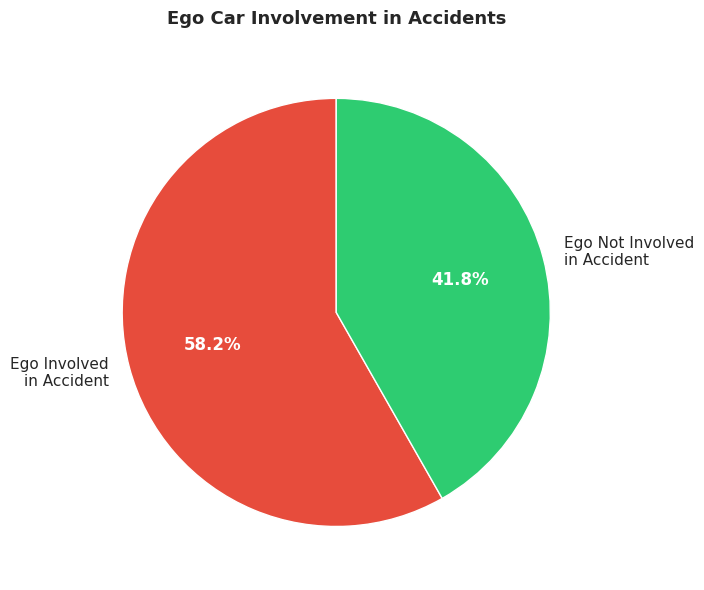

In [50]:
metrics = get_full_dataset_metrics()
print(f"Total Frames: {metrics['total_frames']:,}")
print(f"Normal Frames: {metrics['normal_frames']:,} ({metrics['normal_frames']/metrics['total_frames']*100:.2f}%)")
print(f"Anomaly Frames: {metrics['anomaly_frames']:,} ({metrics['anomaly_frames']/metrics['total_frames']*100:.2f}%)")
print()
print(f"Average Video Length: {metrics['avg_video_length']:.2f} frames")
print(f"Average Anomaly Duration: {metrics['avg_anomaly_duration']:.2f} frames (std: {np.std(metrics['anomaly_durations']):.2f})")
print(f"Average Normal Duration: {metrics['avg_normal_duration']:.2f} frames (std: {np.std(metrics['total_normal_frame_list']):.2f})")
print(f"Average Pre-Anomaly Duration: {np.mean(metrics['pre_anomaly_durations']):.2f} frames (std: {np.std(metrics['pre_anomaly_durations']):.2f})")
print(f"Average Post-Anomaly Duration: {np.mean(metrics['post_anomaly_durations']):.2f} frames (std: {np.std(metrics['post_anomaly_durations']):.2f})")
plot_statistics(metrics)


In [46]:
print(f"The average video length {metrics["avg_video_length"]:0.2f} frames")
print(f"The average avg_anomaly_duration length {metrics["avg_anomaly_duration"]:0.2f} frames")
print(f"The average avg_normal_duration length {metrics["avg_normal_duration"]:0.2f} frames")

The average video length 102.13 frames
The average avg_anomaly_duration length 34.51 frames
The average avg_normal_duration length 67.62 frames


#### Get Metrics for the train set

Processed 4209 videos from train_val.txt
Found 153132 total objects across all frames
Total Frames: 429,113
Normal Frames: 283,445 (66.05%)
Anomaly Frames: 145,668 (33.95%)

Average Video Length: 101.95 frames
Average Anomaly Duration: 34.61 frames (std: 20.15)
Average Normal Duration: 67.34 frames (std: 26.73)
Average Pre-Anomaly Duration: 38.12 frames (std: 17.43)
Average Post-Anomaly Duration: 29.22 frames (std: 22.02)


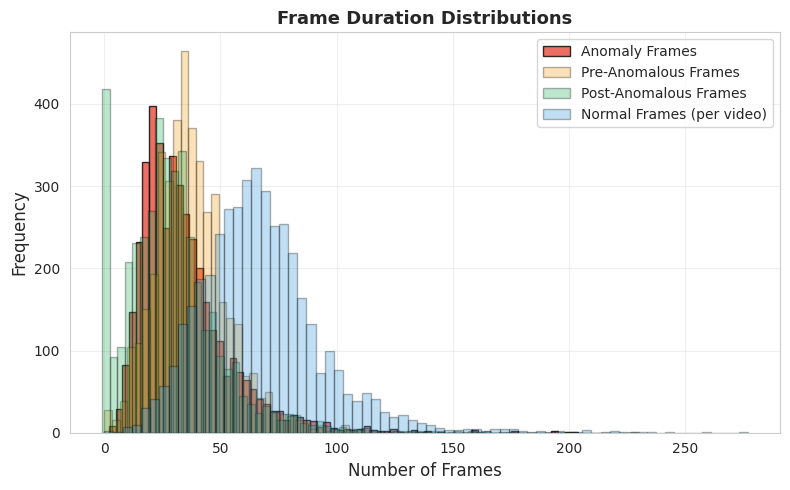

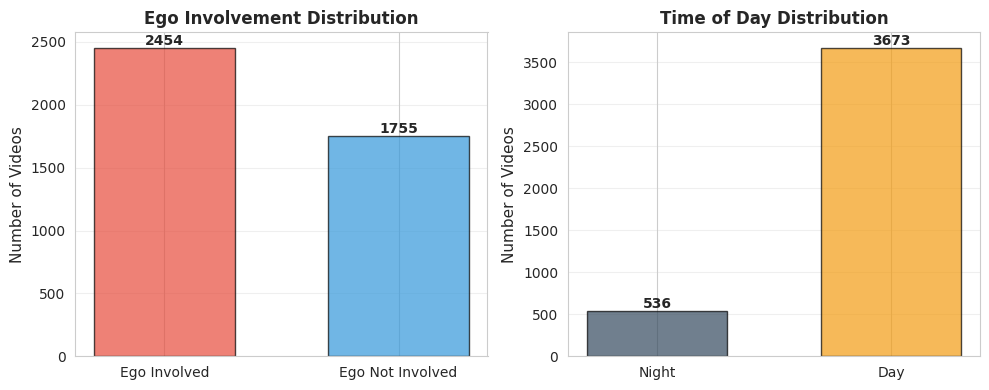

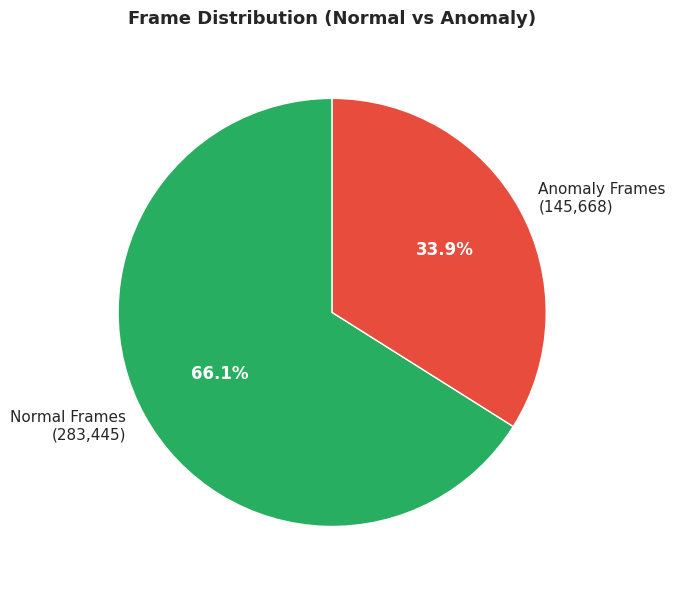

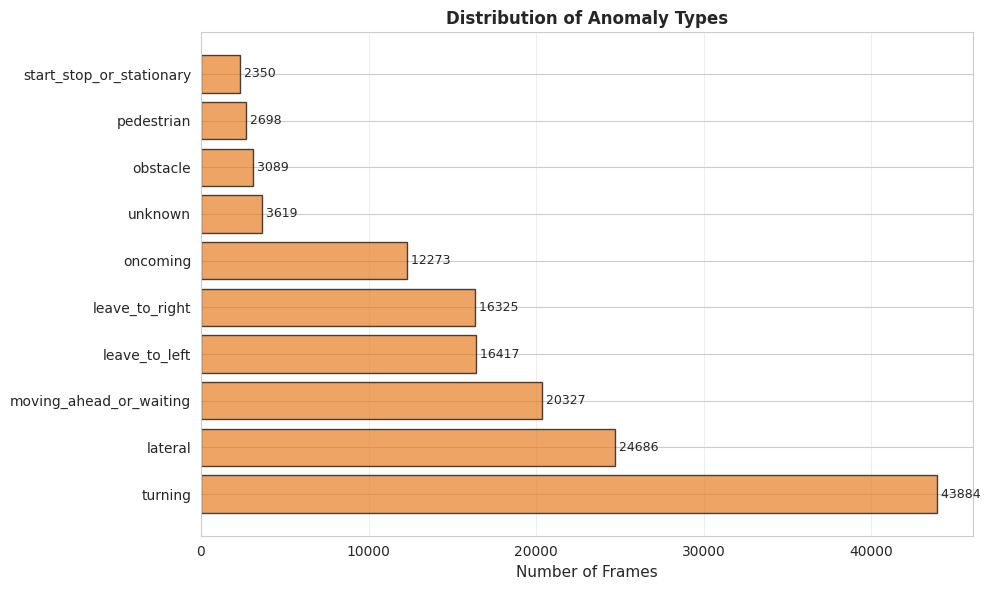

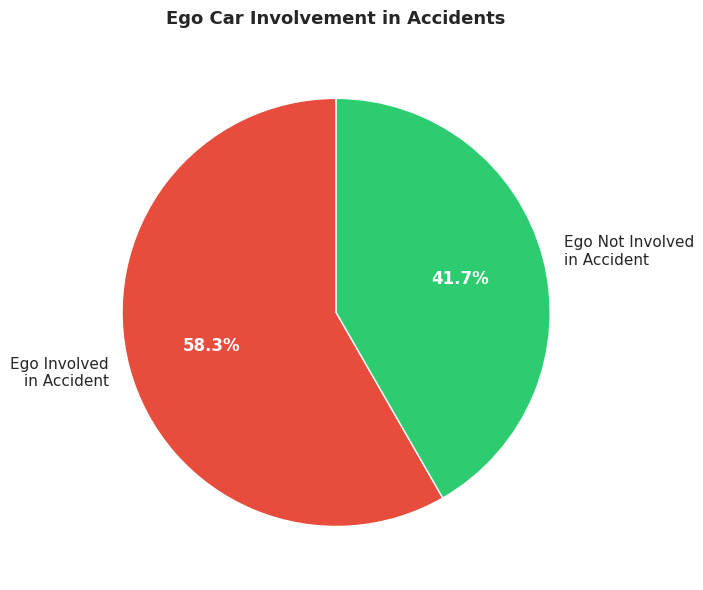

In [51]:
metrics = get_full_dataset_metrics(json_list_file="train_val.txt")
print(f"Total Frames: {metrics['total_frames']:,}")
print(f"Normal Frames: {metrics['normal_frames']:,} ({metrics['normal_frames']/metrics['total_frames']*100:.2f}%)")
print(f"Anomaly Frames: {metrics['anomaly_frames']:,} ({metrics['anomaly_frames']/metrics['total_frames']*100:.2f}%)")
print()
print(f"Average Video Length: {metrics['avg_video_length']:.2f} frames")
print(f"Average Anomaly Duration: {metrics['avg_anomaly_duration']:.2f} frames (std: {np.std(metrics['anomaly_durations']):.2f})")
print(f"Average Normal Duration: {metrics['avg_normal_duration']:.2f} frames (std: {np.std(metrics['total_normal_frame_list']):.2f})")
print(f"Average Pre-Anomaly Duration: {np.mean(metrics['pre_anomaly_durations']):.2f} frames (std: {np.std(metrics['pre_anomaly_durations']):.2f})")
print(f"Average Post-Anomaly Duration: {np.mean(metrics['post_anomaly_durations']):.2f} frames (std: {np.std(metrics['post_anomaly_durations']):.2f})")
plot_statistics(metrics)

#### Get Metrics for the test set

Processed 468 videos from test.txt
Found 17607 total objects across all frames
Total Frames: 48,542
Normal Frames: 32,805 (67.58%)
Anomaly Frames: 15,737 (32.42%)

Average Video Length: 103.72 frames
Average Anomaly Duration: 33.63 frames (std: 19.42)
Average Normal Duration: 70.10 frames (std: 32.76)
Average Pre-Anomaly Duration: 37.49 frames (std: 19.19)
Average Post-Anomaly Duration: 32.61 frames (std: 28.31)


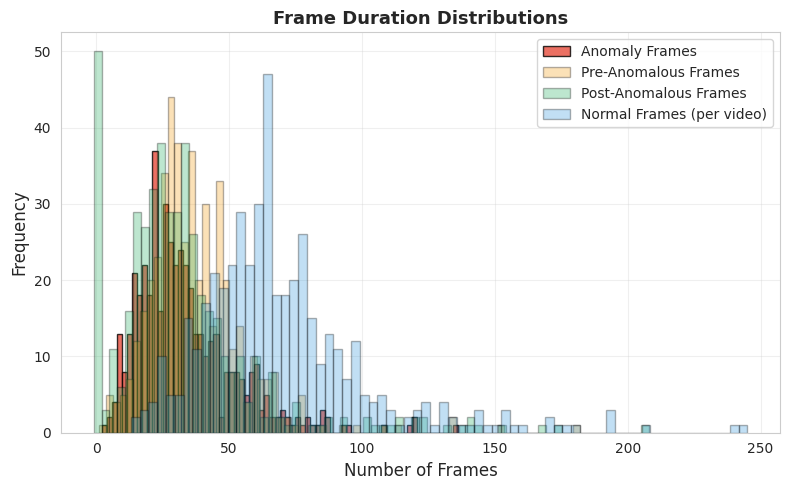

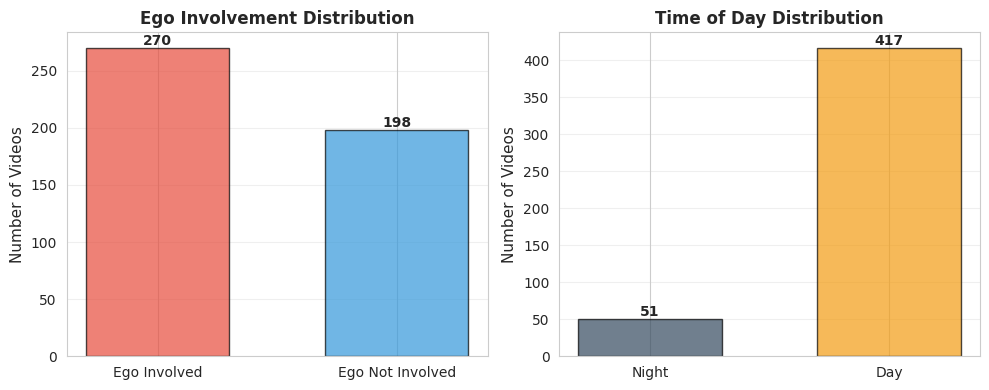

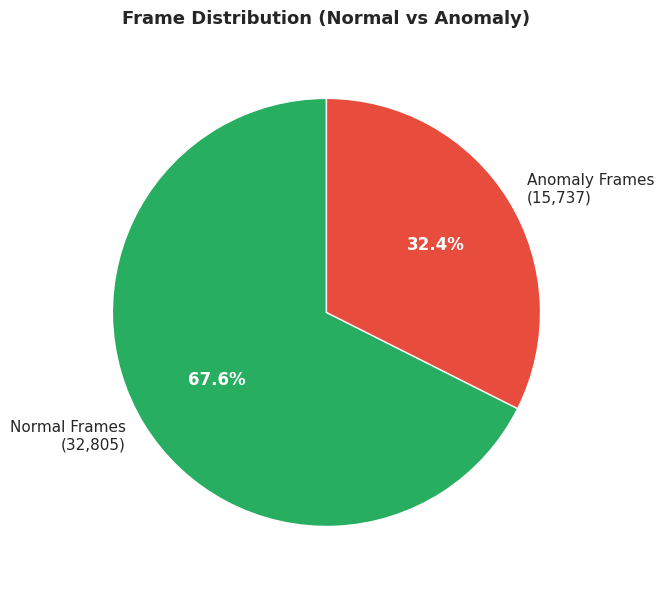

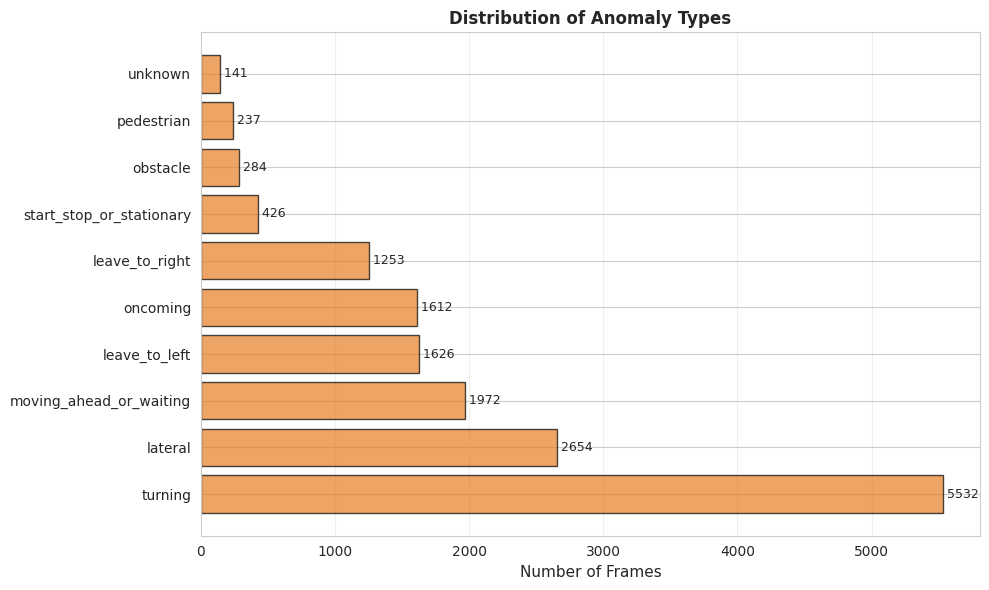

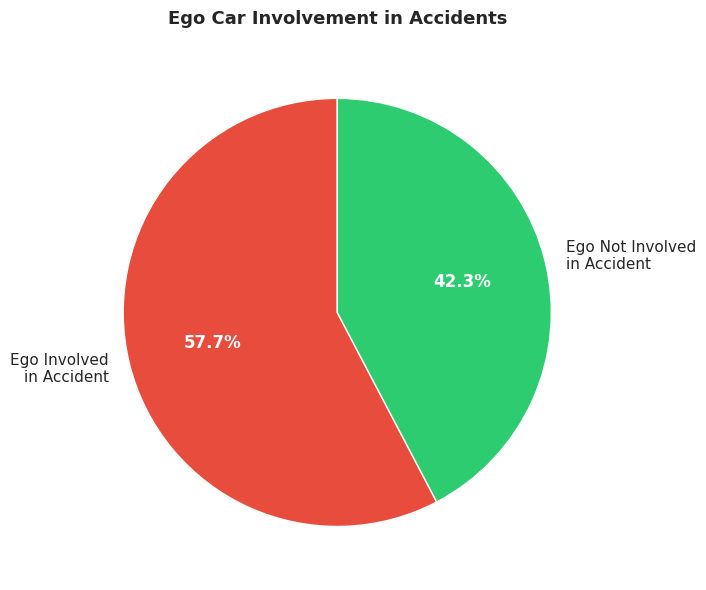

In [52]:
metrics = get_full_dataset_metrics(json_list_file="test.txt")
print(f"Total Frames: {metrics['total_frames']:,}")
print(f"Normal Frames: {metrics['normal_frames']:,} ({metrics['normal_frames']/metrics['total_frames']*100:.2f}%)")
print(f"Anomaly Frames: {metrics['anomaly_frames']:,} ({metrics['anomaly_frames']/metrics['total_frames']*100:.2f}%)")
print()
print(f"Average Video Length: {metrics['avg_video_length']:.2f} frames")
print(f"Average Anomaly Duration: {metrics['avg_anomaly_duration']:.2f} frames (std: {np.std(metrics['anomaly_durations']):.2f})")
print(f"Average Normal Duration: {metrics['avg_normal_duration']:.2f} frames (std: {np.std(metrics['total_normal_frame_list']):.2f})")
print(f"Average Pre-Anomaly Duration: {np.mean(metrics['pre_anomaly_durations']):.2f} frames (std: {np.std(metrics['pre_anomaly_durations']):.2f})")
print(f"Average Post-Anomaly Duration: {np.mean(metrics['post_anomaly_durations']):.2f} frames (std: {np.std(metrics['post_anomaly_durations']):.2f})")
plot_statistics(metrics)
